In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [4]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [5]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# GAGAG motif distributions

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyranges as pr
from tqdm import tqdm
import seaborn as sns

In [3]:
# GAF motifs from ChIP-seq
ALL_motifs = pd.read_csv('./GAGAG_dm3.csv')
# nucleosome positions
nucleosomes = pr.read_bed('./dmNuc0210501.nucleosome.iNPSPeak.bed')

In [4]:
from collections import Counter

def find_motifs_between_dyads(chrom, motif):
    """
    Identify the distribution of the number of complete motifs between nucleosome dyads.
    
    Parameters:
    chrom (list or np.array): {0, 1} sequence where 0 represents free DNA and 1 represents dyad of nucleosome.
    motif (pd.DataFrame): DataFrame with "start" and "end" columns indicating motif positions.

    Returns:
    dict: Distribution of the number of motifs between dyads.
    """
    
    # Find indices of dyads
    dyad_indices = []
    for i, row in chrom.df.iterrows():
        if row.Name.split(':')[1].strip() == 'MainPeak':
            midleft = int(np.floor((row['Start'] + row['End'])/2))
            dyad_indices.append(midleft)

    # Ensure dyad_indices is sorted
    dyad_indices.sort()
    
    # Count complete motifs between consecutive dyads
    motif_counts = []
    for i in range(len(dyad_indices) - 1):
        start_dyad = dyad_indices[i]
        end_dyad = dyad_indices[i + 1]
        
        # Count motifs completely between the current dyads
        count = sum((motif["start"] > start_dyad) & (motif["end"] < end_dyad))
        motif_counts.append(count)

    # Calculate the distribution of motif counts
    distribution = dict(Counter(motif_counts))
    
    return distribution

# Example usage
distributions_all = []
for chrom in ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY']:
    print(chrom, end='... ')
    distributions_all.append(find_motifs_between_dyads(
        nucleosomes[chrom], ALL_motifs[ALL_motifs['chr']==chrom]
    ))
print('end.')
# print(distribution)


chr2L... chr2R... chr3L... chr3R... chr4... chrX... chrY... end.


In [18]:
from collections import Counter

def find_dyad_spacing(chrom):
    """
    Identify the distribution of the number of complete motifs between nucleosome dyads.
    
    Parameters:
    chrom (list or np.array): {0, 1} sequence where 0 represents free DNA and 1 represents dyad of nucleosome.

    Returns:
    dict: Distances between dyads.
    """
    
    # Find indices of dyads
    dyad_indices = []
    for i, row in chrom.df.iterrows():
        if row.Name.split(':')[1].strip() == 'MainPeak':
            midleft = int(np.floor((row['Start'] + row['End'])/2))
            dyad_indices.append(midleft)

    # Ensure dyad_indices is sorted
    dyad_indices.sort()
    
    return np.diff(dyad_indices)

# Example usage
distances_all = []
for chrom in ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY']:
    print(chrom, end='... ')
    distances_all.append(find_dyad_spacing(nucleosomes[chrom]))
print('end.')
# print(distribution)


chr2L... chr2R... chr3L... chr3R... chr4... chrX... chrY... end.


In [8]:
distribution_all_combined = {}
for distribution in distributions_all:
    for count in distribution.keys():
        if count > 0:
            if count in distribution_all_combined:
                distribution_all_combined[count] += distribution[count]
            else:
                distribution_all_combined[count] = distribution[count]

threshold = 8
for count in list(distribution_all_combined.keys()):
    if count > threshold:
        distribution_all_combined[threshold] += distribution_all_combined.pop(count)

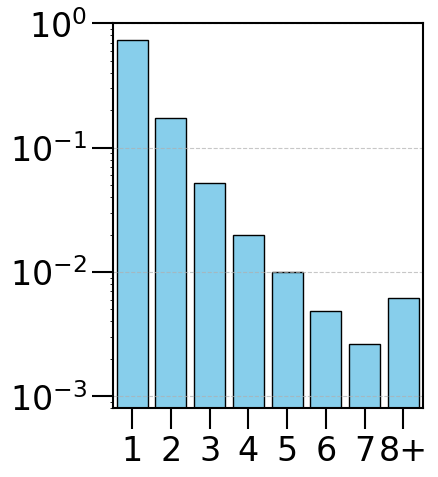

In [12]:
counts = np.array(list(distribution_all_combined.keys()))
frequencies = np.array(list(distribution_all_combined.values()))


ax, colors, linsStyles, legend, labelfont, tickfont, C0 = plotHeader(
    sizeX=4, sizeY=5, spineLineW=1.5, tickW=1.5, tickFontSize=24, labelFontSize=20, 
)

# Create a bar plot
plt.bar(counts, frequencies/np.sum(frequencies), color='skyblue', edgecolor='black')

# Add labels and title
# plt.xlabel('Number of GAF Motifs Between Dyads', **labelfont)
# plt.ylabel('Frequency', **labelfont)
plt.semilogy()

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1,9), ['1', '2', '3', '4', '5', '6', '7', '8+'], **tickfont)
plt.yticks(**tickfont)
plt.xlim([0.5,8.5])
plt.ylim([0.8e-3,1e0])
plt.show()

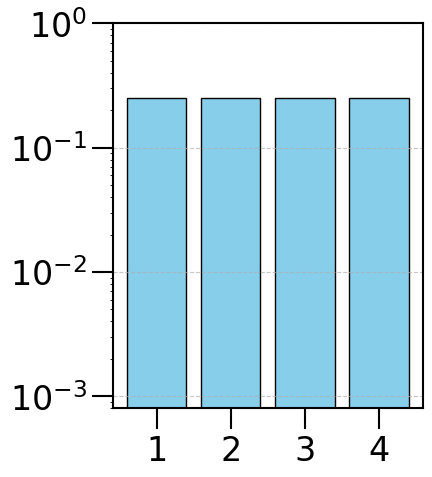

In [14]:
counts = np.array(list(distribution_all_combined.keys()))
frequencies = np.array(list(distribution_all_combined.values()))


ax, colors, linsStyles, legend, labelfont, tickfont, C0 = plotHeader(
    sizeX=4, sizeY=5, spineLineW=1.5, tickW=1.5, tickFontSize=24, labelFontSize=20, 
)

# Create a bar plot
plt.bar([1,2,3,4], [0.25, 0.25, 0.25, 0.25], color='skyblue', edgecolor='black')

# Add labels and title
# plt.xlabel('Number of GAF Motifs Between Dyads', **labelfont)
# plt.ylabel('Frequency', **labelfont)
plt.semilogy()

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.ylim([0.8e-3,1e0])
plt.show()

# f) and g) How population influences

In [6]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], KPS=lambda KPN: 1000, area3Dto1D=[10], 
    kbPP_fixed=0.4, kaPN=0.02*1e6, kaPS=0.1*1e6, lengthScale=scale
)

In [30]:
parms = GenParms(NS=1, scale=2, KPP=1e4, NP0=[1])
upperlimit = 1 + parms['KPS']*parms['KPS']*parms['CS0']*0.6022 / 2
parms = parms.to_numpy()[0]

In [13]:
def theta_DNA(parm):
    equi = numericSolver(parm, rxnNonly, labelsNonly, ifprint=False)
    theta = num.calc_BoundRatio_modelA(parm=parm.iloc[0], equi=equi.iloc[0])
    return theta

# Only one separated target not two
def theta_singleS(parm):
    equi = numericSolver(parm, rxnSingleS, labelsSingleS, ifprint=False)
    parm_loc = parm.iloc[0].copy()
    parm_loc['CS0'] = parm_loc['CS0'] / 2 
    theta = num.calc_BoundRatio_modelB(parm=parm.iloc[0], equi=equi.iloc[0])
    return theta

def theta_doubleS(parm):
    equi = numericSolver(parm, rxnDoubleS, labelsDoubleS, ifprint=False)
    theta = num.calc_BoundRatio_modelC(parm=parm.iloc[0], equi=equi.iloc[0])
    return theta

def freeProDiff(NP1, model1, model2, pop1, pop2, Ntot = 2, KPP = 1e6, NS = 2, scale = 2):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1]) / pop1
    else:
        N1 = NP1 / pop1
    N2 = (Ntot - N1*pop1) / pop2
    if N1[0] < 1e-9:
        parm2 = GenParms(N2, NS, scale, KPP)
        theta2 = model2(parm2)
        return -(N2*(1-theta2))[0]
    elif N2[0] < 1e-9:
        parm1 = GenParms(N1, NS, scale, KPP)
        theta1 = model1(parm1)
        return (N1*(1-theta1))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(N2, NS, scale, KPP)
        theta1 = model1(parm1)
        theta2 = model2(parm2)
        return (N1*(1-theta1) - N2*(1-theta2))[0]
    
def pBoundRatios(NP1, model1, model2, pop1, pop2, Ntot = 2, KPP = 1e6, NS = 2, scale = 2):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1]) / pop1
    else:
        N1 = NP1 / pop1
    N2 = (Ntot - N1*pop1) / pop2
    if N1[0] < 1e-9:
        parm2 = GenParms(N2, NS, scale, KPP)
        theta2 = model2(parm2)
        return 0, theta2
    elif N2[0] < 1e-9:
        parm1 = GenParms(N1, NS, scale, KPP)
        theta1 = model1(parm1)
        return theta1, 0
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(N2, NS, scale, KPP)
        theta1 = model1(parm1)
        theta2 = model2(parm2)
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, pop1, pop2, theta1, theta2):
    return theta1*(N1/pop1), theta2*(Ntot - N1)/pop2

In [14]:
pop1List = np.arange(1,20.5,1) # How many linkers have two separated targets
pop2 = 1 # How many linkers have two clustered targets
ptotList = pop1List + 2 # The total number of proteins
kpp = 1e4

In [15]:
clustered_onDNA = []
separated_onDNA = []
for i, pop1 in enumerate(progressbar(pop1List)):
    Ptot = ptotList[i]
    spr_n = []
    cls_n = []
    r_dimer = root_scalar(
        freeProDiff, x0=Ptot/2, x1=0, xtol=1e-12, 
        args=(theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    )
    th1, th2 = pBoundRatios(r_dimer.root, theta_singleS, theta_doubleS, pop1, pop2, Ptot, kpp)
    spr, cls = proteinsOnDNA(r_dimer.root, Ptot, pop1, pop2, th1, th2)
    clustered_onDNA.append(cls)
    separated_onDNA.append(spr)
clustered_onDNA_changeP = np.array(clustered_onDNA)
separated_onDNA_changeP = np.array(separated_onDNA)

100% (20 of 20) |########################| Elapsed Time: 0:01:07 Time:  0:01:07


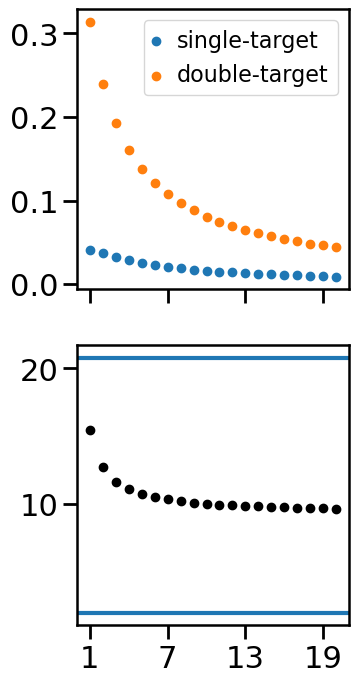

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(3.5, 8), sharex=True, gridspec_kw={'hspace': 0.2})  # Share x-axis

labelfontsize = 22 # set x- and y- label font sizes
tickwidth = 2 # set the width of ticks
ticklength = 10 # set the length of ticks
for a in ax:
    for spine in a.spines.values():
        spine.set_linewidth(1.8)  # Thicker frame lines


# First subplot
ax[0].scatter(pop1List, separated_onDNA_changeP / ptotList, label='single-target')
ax[0].scatter(pop1List, clustered_onDNA_changeP / 2 / ptotList, label='double-target')

ax[0].legend(
    fontsize=16, frameon=True, handlelength=0.3
)
ax[0].set_xticks(np.arange(1, 20.5, 6))
ax[0].tick_params(axis='x', labelsize=labelfontsize, width=tickwidth, length=ticklength)  
ax[0].tick_params(axis='y', labelsize=labelfontsize, width=tickwidth, length=ticklength)

# ax[0].set_title('$N_P^{tot}$ = $N_S^{tot}$', fontsize=18)

# Second subplot
ax[1].scatter(pop1List, clustered_onDNA_changeP / separated_onDNA_changeP, color='black')
ax[1].axhline(upperlimit[0], lw=3)
ax[1].axhline(2, lw=3)

ax[1].tick_params(axis='x', labelsize=labelfontsize, width=tickwidth, length=ticklength)
ax[1].tick_params(axis='y', labelsize=labelfontsize, width=tickwidth, length=ticklength)

# ax[1].set_xlabel('Number of single-target sites', fontsize=20)  # Move xlabel here
plt.show()